Import required packages

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy import distance
import folium
import requests
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Import Foursquare credentials from json file created to preserve secrecy and store in global variables CLIENT_ID and CLIENT_SECRET

In [2]:
import json
globals().update(json.loads(open("foursquareCredentials.json", "r") .read()))
VERSION = '20181124' # Foursquare API version

## Input the variables that define the problem
Get longitude and latitude of location where we want to open a new business

In [3]:
geolocator = Nominatim(user_agent="specify_your_app_name_here")
#location = geolocator.geocode("Rumbach Sebestyén u., Budapest, 1075 Hungary")
#location = geolocator.geocode("Galley Ave, Toronto")
location = geolocator.geocode("st dunstans st, canterbury uk")
lat = location.latitude
long = location.longitude

Populate variables containing the other parameters of the search problem:
* categoryId = foursquare categoryId of the business we wish to open. A full list of categories can be found here: https://developer.foursquare.com/docs/resources/categories.
* radius = the maximum distance from the location within which we want to open the business in km.
* tick = the level of accuracy in km which we want to return for the recommended locations. 

In [4]:
categoryId = '4bf58dd8d48988d16d941735' # Café
radius = 2
tick = 0.2

## Build grid of points within radius of location
Define function degreeLen which for a given lat and long returns the length of a degree of lat and long in km

In [5]:
def degreeLen(lat, long):
    """Returns the lengths of a single degree of latitude and longitude in km for a given latitude and longitude
    """
    # get length of 1 degree at current latidude and logitude
    latDegree = distance.distance((lat - 0.5, long), (lat + 0.5, long)).km
    longDegree = distance.distance((lat, long - 0.5), (lat, long + 0.5)).km
    return latDegree, longDegree
degreeLen(lat, long)

(111.25368725396821, 69.76902172293872)

Define function grid that returns the set of grid points within a circle around location.  Grid points are a distance tick apart.

In [6]:
def grid(lat, long, radius, tick):
    """Returns a set whose elements are a grid of points within a circle around a location
    :param lat: latitude of centre of grid
    :param long: longitude of centre of grid
    :param radius: radius of grid in km
    :param tick: distance between points in grid in km
    """
    # get length of 1 degree at current latidude and logitude
    latDegree, longDegree = degreeLen(lat, long)
    
    # get length of 1 tick in degrees
    latTick = tick / latDegree
    longTick = tick / longDegree
    
    # get coordinates of point which is one radius to the South and West of (lat, long)
    bottomLeft = (lat - radius / latDegree, long - radius / longDegree)
    
    # get tick points along axis
    gridLats = np.arange(2 * radius / tick + 1) * latTick + bottomLeft[0]
    gridLongs = np.arange(2 * radius / tick + 1) * longTick + bottomLeft[1]
    
    # create the set grid made up of points within radius of lat, long, disance tick apart 
    grid = {(lt, lg) for lt in gridLats for lg in gridLongs if distance.distance((lat, long), (lt, lg)).km <= radius}
    
    return grid

Check grid function is working using Folium

In [7]:
g = grid(lat, long, radius, tick)
# create map
map_grid = folium.Map(location=[lat, long], zoom_start=13)

for (lt, lg) in g:
    folium.CircleMarker([lt, lg],
                        radius=2,
                        fill=True,
                        fill_opacity=0.5).add_to(map_grid)
print("Number of points in grid = " + str(len(g)))      
map_grid

Number of points in grid = 310


## Build function which pulls venue data from Foursquare
Define function for pulling list of nearby venues, with optional filter on category Id

In [8]:
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&intent=browse&ll={},{}&radius={}&categoryId={}'
def getNearbyVenues(lat, long, radius, categoryId = ''):
    apiCall = url.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, long, radius, categoryId)
    venues = requests.get(apiCall).json()['response']['venues']
    venues_list=[]
    
    for v in venues:
        if len(v['categories']) > 0:
            venues_list.append([v['id'], v['name'], v['location']['distance'], v['categories'][0]['name']])
        else:
            venues_list.append([v['id'], v['name'], v['location']['distance'], 'None'])
    
    return(venues_list)

Check function getNearbyVenues is working

In [9]:
getNearbyVenues(lat, long, tick * 1000, categoryId)

[]

## Build function to calculate density of venues within a specified radius of a location
Define function venueDensity which outputs a measure the density of a list of venues within a specific radius of a location.
The density measure has the property of being larger the more venues there are in the list and the closer they are.
So for each venue we subtract the distance of the venue from the location from the radius.
This measure is then summed up for all the venues

Worked example, radius = 200m, 2 venues, 1 distance 1m from the location, the other distance 199m:
* venue 1 density = 200 - 1 = 199
* venue 2 density = 200 - 199 = 1
* total density = 199 + 1 = 200

In [10]:
def venueDensity(venues, radius):
    distances = []
    [distances.append(radius - v[2]) for v in venues if v[2] < radius]
    return np.sum(np.asarray(distances))

In [11]:
venueDensity(getNearbyVenues(lat, long, tick * 1000, categoryId), tick * 1000)

0.0

In [12]:
# Check if density for empty list of venues = 0
venueDensity([], tick * 1000)

0.0

## Get venue density for each point on the grid around location

In [13]:
targets = []
ids = set()
for (lt, lg) in g:
    print((lt, lg))
    venues = getNearbyVenues(lt, lg, tick * 1000, categoryId)
    density = venueDensity(venues, tick * 1000)
    targets.append((lt, lg, density))
    for (v_id, name, distance, category) in venues:
        ids.add(v_id)

(51.29393325935902, 1.089538910520058)
(51.29573095258552, 1.0551396894799423)
(51.29393325935902, 1.086672308766715)
(51.27775402032049, 1.0608728929866282)
(51.279551713546994, 1.0608728929866282)
(51.281349406773494, 1.0608728929866282)
(51.2831471, 1.0608728929866282)
(51.2849447932265, 1.0608728929866282)
(51.28674248645301, 1.0608728929866282)
(51.28854017967951, 1.0608728929866282)
(51.290337872906015, 1.0608728929866282)
(51.292135566132515, 1.0608728929866282)
(51.29393325935902, 1.0608728929866282)
(51.29573095258552, 1.0522730877265993)
(51.29752864581203, 1.0694726982466571)
(51.29752864581203, 1.078072503506686)
(51.29752864581203, 1.075205901753343)
(51.266967860961465, 1.075205901753343)
(51.26876555418797, 1.075205901753343)
(51.27236094064098, 1.075205901753343)
(51.26876555418797, 1.0608728929866282)
(51.266967860961465, 1.0608728929866282)
(51.27056324741447, 1.0608728929866282)
(51.27056324741447, 1.083805707013372)
(51.27236094064098, 1.0580062912332853)
(51.272360

(51.27056324741447, 1.0723393)
(51.27236094064098, 1.0723393)
(51.27415863386748, 1.0723393)
(51.275956327093986, 1.0723393)
(51.27775402032049, 1.0723393)
(51.279551713546994, 1.0723393)
(51.281349406773494, 1.0723393)
(51.28674248645301, 1.078072503506686)
(51.29932633903853, 1.078072503506686)
(51.28674248645301, 1.075205901753343)
(51.290337872906015, 1.0551396894799423)
(51.29573095258552, 1.0608728929866282)
(51.29932633903853, 1.075205901753343)
(51.290337872906015, 1.0522730877265993)
(51.28854017967951, 1.0694726982466571)
(51.29932633903853, 1.083805707013372)
(51.28854017967951, 1.078072503506686)
(51.275956327093986, 1.075205901753343)
(51.28854017967951, 1.075205901753343)
(51.292135566132515, 1.080939105260029)
(51.29393325935902, 1.0924055122734009)
(51.26876555418797, 1.083805707013372)
(51.266967860961465, 1.083805707013372)
(51.275956327093986, 1.083805707013372)
(51.27775402032049, 1.083805707013372)
(51.279551713546994, 1.083805707013372)
(51.281349406773494, 1.0838

In [14]:
targetsDf = pd.DataFrame(targets)
targetsDf.columns = ['Latitude', 'Longitude', 'Density']
targetsDf.set_index(['Latitude', 'Longitude'], inplace=True)
targetsDf.sort_index(inplace=True)
targetsDf

Density
Latitude  Longitude         
51.265170 1.072339       0.0
51.266968 1.060873       0.0
          1.063739       0.0
          1.066606       0.0
          1.069473       0.0
          1.072339       0.0
          1.075206       0.0
          1.078073       0.0
          1.080939       0.0
          1.083806       0.0
51.268766 1.058006       0.0
          1.060873       0.0
          1.063739      35.0
          1.066606     128.0
          1.069473       0.0
          1.072339       0.0
          1.075206       0.0
          1.078073       0.0
          1.080939       0.0
          1.083806       0.0
          1.086672       0.0
51.270563 1.052273       0.0
          1.055140       0.0
          1.058006       0.0
          1.060873     168.0
          1.063739     228.0
          1.066606      51.0
          1.069473       8.0
          1.072339       0.0
          1.075206       0.0
...                      ...
51.295731 1.072339       0.0
          1.075206       0.0
          1.078073       0.0
          1.080939       0.0
          1.083806       0.0
          1.086672       0.0
          1.089539       0.0
          1.092406       0.0
51.297529 1.055140       0.0
          1.058006       0.0
          1.060873      46.0
          1.063739     201.0
          1.066606      68.0
          1.069473     297.0
          1.072339      10.0
          1.075206       0.0
          1.078073       0.0
          1.080939       0.0
          1.083806       0.0
          1.086672       0.0
          1.089539       0.0
51.299326 1.060873      48.0
          1.063739      72.0
          1.066606       0.0
          1.069473      98.0
          1.072339       0.0
          1.075206       0.0
          1.078073       0.0
          1.080939       0.0
          1.083806       0.0

[310 rows x 1 columns]

In [15]:
targetsDf.describe()

,Density
count,310.000000
mean,33.296774
std,117.411878
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1330.000000


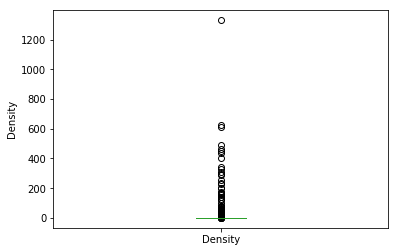

In [16]:
targetsDf.plot(y='Density', kind='box')
plt.ylabel('Density')
plt.show()

In [17]:
targetsDf['Log Density'] = np.log10(targetsDf['Density'].values + 1)

In [18]:
targetsDf.describe()

,Density,Log Density
count,310.000000,310.000000
mean,33.296774,0.371167
std,117.411878,0.803459
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1330.000000,3.124178


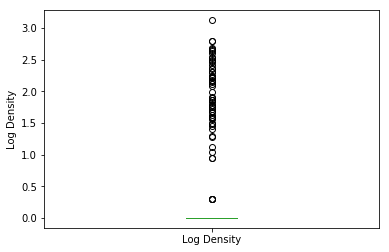

In [19]:
targetsDf.plot(y='Log Density', kind='box')
plt.ylabel('Log Density')
plt.show()

In [20]:
ids

{'4b9faacbf964a520213337e3',
 '4bb34b1f35f0c9b6bb29bc83',
 '4bbeff6af353d13ae2e87d10',
 '4bdc8b30afe8c9b61fec4f85',
 '4be36a92fe2995218b94966c',
 '4bee71f33686c9b68684246e',
 '4c2b2e232219c928c81ea448',
 '4c3dd8b0ea36ef3b92517285',
 '4c3efad11ef0d13ac4fb9280',
 '4c5a9fb0f54376b076ca848b',
 '4c7e5156d598a0934e57c562',
 '4c83742551ada1cd38ea2510',
 '4c84e21fdc018cfabcd7e36c',
 '4c99b19f78fc236a01282f97',
 '4ca74f4f44a8224b89b40b40',
 '4cb08643aef16dcbe974b154',
 '4cb99428dd41a35dce69e2a0',
 '4ccfdd640d9b952182868ea3',
 '4cf90a7ede096dcb13198c79',
 '4cfa1136c671721e073dbb18',
 '4d0b8db8984a6ea881279264',
 '4d2b25428e102c0f0b71d16e',
 '4dc14e1ad16455f832256082',
 '4e3e9970e4cdab9b93522c8d',
 '4e6b2e6852b1c1206022b89e',
 '4e9857544901ee0ca4b38d20',
 '4ecfad9c8b81b473959befc2',
 '4f130abfe4b0958ec2d8b175',
 '4f551551e4b040bb62e0ec81',
 '4f5b89d6e4b0a61f4b2e17a5',
 '4fc8b489e4b00f559926d98e',
 '50506fb8e4b0361aabb39d57',
 '510a662ce4b090e4573ea18f',
 '5114ff0de4b0c912ccb00b75',
 '51613e0fe4b0

In [21]:
otherVenues = []
for (lt, lg) in g:
    print((lt, lg))
    venues = getNearbyVenues(lt, lg, tick * 1000)
    for (v_id, name, distance, category) in venues:
        if not (v_id in ids) and category != 'None' and distance < tick * 1000 :
            otherVenues.append((lt, lg, v_id, name, distance, category))

(51.29393325935902, 1.089538910520058)
(51.29573095258552, 1.0551396894799423)
(51.29393325935902, 1.086672308766715)
(51.27775402032049, 1.0608728929866282)
(51.279551713546994, 1.0608728929866282)
(51.281349406773494, 1.0608728929866282)
(51.2831471, 1.0608728929866282)
(51.2849447932265, 1.0608728929866282)
(51.28674248645301, 1.0608728929866282)
(51.28854017967951, 1.0608728929866282)
(51.290337872906015, 1.0608728929866282)
(51.292135566132515, 1.0608728929866282)
(51.29393325935902, 1.0608728929866282)
(51.29573095258552, 1.0522730877265993)
(51.29752864581203, 1.0694726982466571)
(51.29752864581203, 1.078072503506686)
(51.29752864581203, 1.075205901753343)
(51.266967860961465, 1.075205901753343)
(51.26876555418797, 1.075205901753343)
(51.27236094064098, 1.075205901753343)
(51.26876555418797, 1.0608728929866282)
(51.266967860961465, 1.0608728929866282)
(51.27056324741447, 1.0608728929866282)
(51.27056324741447, 1.083805707013372)
(51.27236094064098, 1.0580062912332853)
(51.272360

(51.27056324741447, 1.0723393)
(51.27236094064098, 1.0723393)
(51.27415863386748, 1.0723393)
(51.275956327093986, 1.0723393)
(51.27775402032049, 1.0723393)
(51.279551713546994, 1.0723393)
(51.281349406773494, 1.0723393)
(51.28674248645301, 1.078072503506686)
(51.29932633903853, 1.078072503506686)
(51.28674248645301, 1.075205901753343)
(51.290337872906015, 1.0551396894799423)
(51.29573095258552, 1.0608728929866282)
(51.29932633903853, 1.075205901753343)
(51.290337872906015, 1.0522730877265993)
(51.28854017967951, 1.0694726982466571)
(51.29932633903853, 1.083805707013372)
(51.28854017967951, 1.078072503506686)
(51.275956327093986, 1.075205901753343)
(51.28854017967951, 1.075205901753343)
(51.292135566132515, 1.080939105260029)
(51.29393325935902, 1.0924055122734009)
(51.26876555418797, 1.083805707013372)
(51.266967860961465, 1.083805707013372)
(51.275956327093986, 1.083805707013372)
(51.27775402032049, 1.083805707013372)
(51.279551713546994, 1.083805707013372)
(51.281349406773494, 1.0838

In [22]:
otherVenuesDf = pd.DataFrame(otherVenues)
otherVenuesDf.columns = ['Latitude', 'Longitude', 'VenueID', 'Name', 'Distance', 'Category']
otherVenuesDf.set_index(['Latitude', 'Longitude'], inplace=True)
otherVenuesDf.sort_index(inplace=True)
otherVenuesDf

VenueID  \
Latitude  Longitude                             
51.266968 1.063739   5bdc7be8237dee002c0b6062   
          1.066606   4e5607dec65be3cea4608c06   
          1.066606   5bdc7be8237dee002c0b6062   
          1.066606   531cd2c1498ec664799ab19e   
          1.069473   4e5607dec65be3cea4608c06   
          1.083806   597e40c581635b3c49ec5f60   
51.268766 1.058006   50744b05e4b0956351672120   
          1.058006   56ed16a6498e9cba7e1dc47a   
          1.063739   4c50144f371520a136d0b1c0   
          1.063739   5bdc7be8237dee002c0b6062   
          1.066606   5bdc7be8237dee002c0b6062   
          1.066606   4e5607dec65be3cea4608c06   
          1.066606   4c50144f371520a136d0b1c0   
          1.072339   4e2a78e352b1b8f19856fc4b   
          1.072339   51eb795f498eac28b4707163   
          1.075206   4e2a78e352b1b8f19856fc4b   
          1.080939   500128e7e4b0f448e8f04846   
          1.080939   50e65770e4b0e23d19846fbe   
          1.083806   4dc697ecd22dafda2fc0d857   
          1.086672   4f15d9c2e4b03856f4beaca1   
          1.086672   4c8f2dbca8de224bd47a2d01   
51.270563 1.055140   4d16584c1356a0939971d582   
          1.058006   5209263011d292650f14a75e   
          1.058006   4d16584c1356a0939971d582   
          1.060873   4b9fb406f964a5206c3637e3   
          1.060873   4deb44167d8b6c7a53554ca3   
          1.060873   4bc4adc6f8219c7458b5b710   
          1.060873   5105369ee4b0269877c9c544   
          1.060873   4d3883f1d60c6dcb42f978bc   
          1.060873   5209263011d292650f14a75e   
...                                       ...   
51.299326 1.072339   4ef09e79e300f78a2de60a8f   
          1.072339   519e4e50498e8660997cc352   
          1.072339   4ddc0fb422713339cd0dbdd1   
          1.072339   4d4892f894ab2c0f23dc110c   
          1.072339   4e8eeaa561afe70d47d4535e   
          1.072339   50abc5cde4b04d7b1724df2d   
          1.072339   56150507498e1b3f7eb50f31   
          1.072339   5966abef4a1cc038eb86048c   
          1.075206   50ae3a2ce4b01493797f8cf6   
          1.075206   4b828f28f964a52045d830e3   
          1.075206   4ee70231823180a98dba22d6   
          1.075206   4eff8a43a69d45461d5c40b6   
          1.075206   4cf3ea6f6195721e37754fc1   
          1.075206   4f5788d9e4b0b1792ebca128   
          1.075206   4ddee38ed4c0872a5cd3fe99   
          1.075206   519e4e50498e8660997cc352   
          1.075206   4ec1601302d5a63a3fcccd76   
          1.075206   506bec6be4b0c5d997da9e80   
          1.075206   4ef09e79e300f78a2de60a8f   
          1.075206   4ec164f3e5fae164652e3dfa   
          1.075206   51db3bcd498e88c9dc1ac137   
          1.075206   50746167e4b023c59de4d55d   
          1.075206   5966abef4a1cc038eb86048c   
          1.075206   4d482292551db1f75aeb9f30   
          1.075206   4ddc0fb422713339cd0dbdd1   
          1.075206   50efd2e5e4b0f29e642060f4   
          1.075206   4d46b4041911a093cacaedd8   
          1.075206   510c127ae4b048d877b93cc3   
          1.075206   506b6ecfe4b0fa7d3a3372f4   
          1.075206   506b4fe2e4b07005233a0131   

                                                       Name  Distance  \
Latitude  Longitude                                                     
51.266968 1.063739                             George House       176   
          1.066606                                IA Palace        76   
          1.066606                             George House       100   
          1.066606                           52 Gilbert way       171   
          1.069473                                IA Palace       132   
          1.083806                       Orchard Residences        80   
51.268766 1.058006                      Saint Nicholas Road        83   
          1.058006              Thannington Resource Centre       155   
          1.063739                                   Dunelm        47   
          1.063739                             George House       189   
          1.066606                             George House       120   
 

In [23]:
otherVenuesDf['Density'] = (tick * 1000) - otherVenuesDf['Distance']
otherVenuesDf

VenueID  \
Latitude  Longitude                             
51.266968 1.063739   5bdc7be8237dee002c0b6062   
          1.066606   4e5607dec65be3cea4608c06   
          1.066606   5bdc7be8237dee002c0b6062   
          1.066606   531cd2c1498ec664799ab19e   
          1.069473   4e5607dec65be3cea4608c06   
          1.083806   597e40c581635b3c49ec5f60   
51.268766 1.058006   50744b05e4b0956351672120   
          1.058006   56ed16a6498e9cba7e1dc47a   
          1.063739   4c50144f371520a136d0b1c0   
          1.063739   5bdc7be8237dee002c0b6062   
          1.066606   5bdc7be8237dee002c0b6062   
          1.066606   4e5607dec65be3cea4608c06   
          1.066606   4c50144f371520a136d0b1c0   
          1.072339   4e2a78e352b1b8f19856fc4b   
          1.072339   51eb795f498eac28b4707163   
          1.075206   4e2a78e352b1b8f19856fc4b   
          1.080939   500128e7e4b0f448e8f04846   
          1.080939   50e65770e4b0e23d19846fbe   
          1.083806   4dc697ecd22dafda2fc0d857   
          1.086672   4f15d9c2e4b03856f4beaca1   
          1.086672   4c8f2dbca8de224bd47a2d01   
51.270563 1.055140   4d16584c1356a0939971d582   
          1.058006   5209263011d292650f14a75e   
          1.058006   4d16584c1356a0939971d582   
          1.060873   4b9fb406f964a5206c3637e3   
          1.060873   4deb44167d8b6c7a53554ca3   
          1.060873   4bc4adc6f8219c7458b5b710   
          1.060873   5105369ee4b0269877c9c544   
          1.060873   4d3883f1d60c6dcb42f978bc   
          1.060873   5209263011d292650f14a75e   
...                                       ...   
51.299326 1.072339   4ef09e79e300f78a2de60a8f   
          1.072339   519e4e50498e8660997cc352   
          1.072339   4ddc0fb422713339cd0dbdd1   
          1.072339   4d4892f894ab2c0f23dc110c   
          1.072339   4e8eeaa561afe70d47d4535e   
          1.072339   50abc5cde4b04d7b1724df2d   
          1.072339   56150507498e1b3f7eb50f31   
          1.072339   5966abef4a1cc038eb86048c   
          1.075206   50ae3a2ce4b01493797f8cf6   
          1.075206   4b828f28f964a52045d830e3   
          1.075206   4ee70231823180a98dba22d6   
          1.075206   4eff8a43a69d45461d5c40b6   
          1.075206   4cf3ea6f6195721e37754fc1   
          1.075206   4f5788d9e4b0b1792ebca128   
          1.075206   4ddee38ed4c0872a5cd3fe99   
          1.075206   519e4e50498e8660997cc352   
          1.075206   4ec1601302d5a63a3fcccd76   
          1.075206   506bec6be4b0c5d997da9e80   
          1.075206   4ef09e79e300f78a2de60a8f   
          1.075206   4ec164f3e5fae164652e3dfa   
          1.075206   51db3bcd498e88c9dc1ac137   
          1.075206   50746167e4b023c59de4d55d   
          1.075206   5966abef4a1cc038eb86048c   
          1.075206   4d482292551db1f75aeb9f30   
          1.075206   4ddc0fb422713339cd0dbdd1   
          1.075206   50efd2e5e4b0f29e642060f4   
          1.075206   4d46b4041911a093cacaedd8   
          1.075206   510c127ae4b048d877b93cc3   
          1.075206   506b6ecfe4b0fa7d3a3372f4   
          1.075206   506b4fe2e4b07005233a0131   

                                                       Name  Distance  \
Latitude  Longitude                                                     
51.266968 1.063739                             George House       176   
          1.066606                                IA Palace        76   
          1.066606                             George House       100   
          1.066606                           52 Gilbert way       171   
          1.069473                                IA Palace       132   
          1.083806                       Orchard Residences        80   
51.268766 1.058006                      Saint Nicholas Road        83   
          1.058006              Thannington Resource Centre       155   
          1.063739                                   Dunelm        47   
          1.063739                             George House       189   
          1.066606                             George House       120   
 

In [24]:
features = pd.pivot_table(otherVenuesDf,index=['Latitude', 'Longitude'],values='Density',
                          columns='Category',aggfunc=[np.sum],fill_value=0)['sum']

In [25]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 236 entries, (51.266967860961465, 1.0637394947399712) to (51.29932633903853, 1.075205901753343)
Columns: 258 entries, Accessories Store to Women's Store
dtypes: int64(258)
memory usage: 476.6 KB


In [26]:
features

Category             Accessories Store  African Restaurant  Art Gallery  \
Latitude  Longitude                                                       
51.266968 1.063739                   0                   0            0   
          1.066606                   0                   0            0   
          1.069473                   0                   0            0   
          1.083806                   0                   0            0   
51.268766 1.058006                   0                   0            0   
          1.063739                   0                   0            0   
          1.066606                   0                   0            0   
          1.072339                   0                   0            0   
          1.075206                   0                   0            0   
          1.080939                   0                   0            0   
          1.083806                   0                   0            0   
          1.086672                   0                   0            0   
51.270563 1.055140                   0                   0            0   
          1.058006                   0                   0            0   
          1.060873                   0                   0            0   
          1.063739                   0                   0            0   
          1.066606                   0                   0            0   
          1.069473                   0                   0            0   
          1.072339                   0                   0            0   
          1.075206                   0                   0            0   
          1.078073                   0                   0            0   
          1.080939                   0                   0            0   
          1.083806                   0                   0            0   
          1.086672                   0                   0            0   
          1.089539                   0                   0            0   
          1.092406                   0                   0            0   
51.272361 1.058006                   0                   0            0   
          1.060873                   0                   0            0   
          1.063739                   0                   0            0   
          1.066606                   0                   0            0   
...                                ...                 ...          ...   
51.293933 1.092406                   0                   0            0   
          1.095272                   0                   0            0   
51.295731 1.055140                   0                   0            0   
          1.058006                   0                   0            0   
          1.060873                   0                   0            0   
          1.063739                   0                   0            0   
          1.066606                   0                   0            0   
          1.069473                   0                   0            0   
          1.072339                   0                   0            0   
          1.075206                   0                   0            0   
          1.078073                   0                   0            0   
          1.080939                   0                   0            0   
          1.086672                   0                   0            0   
          1.089539                   0                   0            0   
51.297529 1.055140                   0                   0            0   
          1.058006                   0                   0            0   
          1.060873                   0                   0            0   
          1.063739                   0                   0            0   
          1.066606                   0                   0            0   
          1.069473                   0                   0            0   
          1.072339       

In [27]:
features.describe()

Category,Accessories Store,African Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Auto Dealership,...,University,Used Bookstore,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Village,Warehouse,Warehouse Store,Wine Shop,Women's Store
count,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,...,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000
mean,0.453390,0.275424,3.809322,0.855932,2.300847,1.995763,6.326271,1.622881,0.826271,1.906780,...,15.720339,0.741525,0.466102,0.364407,0.542373,0.872881,0.402542,2.474576,0.902542,0.830508
std,6.965107,4.231140,25.833873,9.497391,15.272788,14.620737,31.676952,13.757387,8.962303,13.425278,...,52.504652,11.133089,6.967013,5.598123,8.332090,9.757526,6.183973,18.133647,9.771160,9.059430
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,107.000000,65.000000,310.000000,123.000000,128.000000,186.000000,285.000000,158.000000,101.000000,124.000000,...,416.000000,171.000000,107.000000,86.000000,128.000000,137.000000,95.000000,180.000000,140.000000,109.000000


In [28]:
features = np.log10(features + 1)

In [29]:
features.describe()

Category,Accessories Store,African Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Auto Dealership,...,University,Used Bookstore,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Village,Warehouse,Warehouse Store,Wine Shop,Women's Store
count,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,...,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000
mean,0.008616,0.007710,0.064195,0.016934,0.048925,0.053706,0.112043,0.034833,0.016891,0.048778,...,0.260131,0.012434,0.011167,0.008218,0.008943,0.020706,0.008399,0.051124,0.022191,0.016889
std,0.132365,0.118442,0.352865,0.183772,0.305050,0.299105,0.456679,0.251966,0.183100,0.289118,...,0.673650,0.152283,0.137885,0.126252,0.137388,0.191313,0.129035,0.304240,0.199187,0.183129
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.033424,1.819544,2.492760,2.093422,2.110590,2.271842,2.456366,2.201397,2.008600,2.096910,...,2.620136,2.235528,2.033424,1.939519,2.110590,2.139879,1.982271,2.257679,2.149219,2.041393


In [30]:
features = features.join(targetsDf).fillna(0).reset_index()

In [31]:
features.describe()

,Latitude,Longitude,Accessories Store,African Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,...,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Village,Warehouse,Warehouse Store,Wine Shop,Women's Store,Density,Log Density
count,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,...,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000
mean,51.283155,1.074429,0.008616,0.007710,0.064195,0.016934,0.048925,0.053706,0.112043,0.034833,...,0.011167,0.008218,0.008943,0.020706,0.008399,0.051124,0.022191,0.016889,43.737288,0.487550
std,0.008798,0.013112,0.132365,0.118442,0.352865,0.183772,0.305050,0.299105,0.456679,0.251966,...,0.137885,0.126252,0.137388,0.191313,0.129035,0.304240,0.199187,0.183129,132.920832,0.889855
min,51.266968,1.046540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.275956,1.063739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51.283147,1.075206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,51.290338,1.086672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.301030
max,51.299326,1.098139,2.033424,1.819544,2.492760,2.093422,2.110590,2.271842,2.456366,2.201397,...,2.033424,1.939519,2.110590,2.139879,1.982271,2.257679,2.149219,2.041393,1330.000000,3.124178


In [32]:
X = features.drop(['Latitude', 'Longitude', 'Density', 'Log Density'], axis=1)
y = features['Log Density']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=22)

In [34]:
reg_all = linear_model.LinearRegression()
reg_all.fit(X_train, y_train)
y_pred_test = reg_all.predict(X_test)
y_pred_train = reg_all.predict(X_train)
reg_all.score(X_test, y_test)

-2.3218516714661777e+23

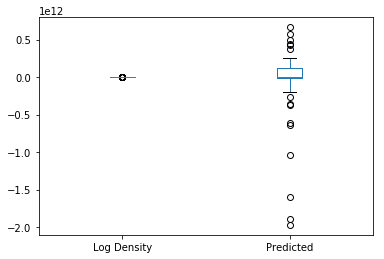

In [35]:
testDf = y_test.to_frame()
testDf['Predicted'] = y_pred_test
testDf.plot(kind='box')
plt.show()

In [36]:
testDf.describe()

,Log Density,Predicted
count,71.000000,7.100000e+01
mean,0.519360,-4.473939e+10
std,0.943695,4.524870e+11
min,0.000000,-1.970228e+12
25%,0.000000,-8.288288e+09
50%,0.000000,2.142301e-01
75%,0.150515,1.252917e+11
max,2.795880,6.653176e+11


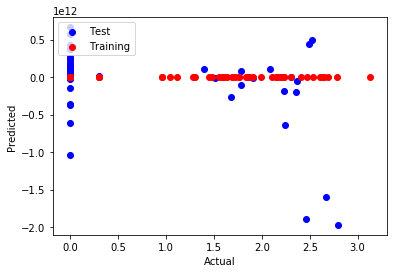

In [37]:
plt.scatter(y_test, y_pred_test, color='blue', label='Test')
plt.scatter(y_train, y_pred_train, color='red', label='Training')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

In [38]:
lasso = linear_model.Lasso(alpha=0.005, normalize=True)
lasso.fit(X_train, y_train)
lasso_pred_test = lasso.predict(X_test)
lasso_pred_train = lasso.predict(X_train)
lasso.score(X_test, y_test)

0.2057319367298912

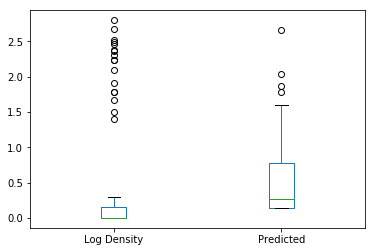

In [39]:
testDf = y_test.to_frame()
testDf['Predicted'] = lasso_pred_test
testDf.plot(kind='box')
plt.show()

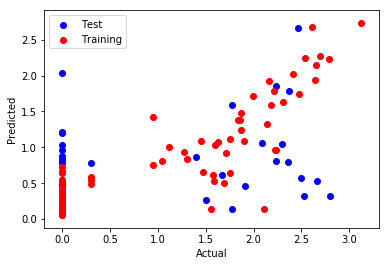

In [40]:
plt.scatter(y_test, lasso_pred_test, color='blue', label='Test')
plt.scatter(y_train, lasso_pred_train, color='red', label='Training')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

In [41]:
lasso_pred_all = lasso.predict(X)

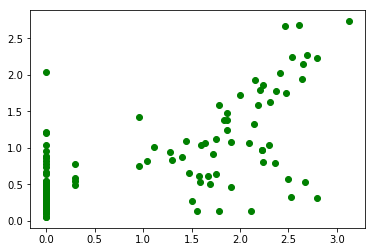

In [42]:
plt.scatter(y, lasso_pred_all, color='green')
plt.show()

In [43]:
len(lasso_pred_all)

236

In [44]:
results = features[['Latitude', 'Longitude', 'Log Density']]

In [45]:
results['Predicted'] = lasso_pred_all

C:\Users\mattc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


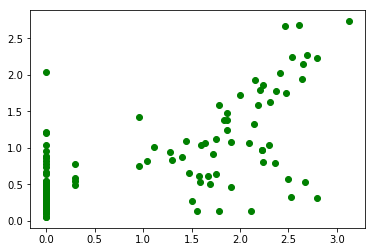

In [46]:
plt.scatter(results['Log Density'], results['Predicted'], color='green')
plt.show()

In [47]:
results['Rank'] = results['Predicted'] / (results['Log Density'] + 1)

C:\Users\mattc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
top10 = results.sort_values(by='Rank', ascending=False).head(10)
top10

,Latitude,Longitude,Log Density,Predicted,Rank
234,51.299326,1.072339,0.000000,2.032219,2.032219
201,51.293933,1.066606,0.000000,1.213653,1.213653
212,51.295731,1.066606,0.000000,1.199750,1.199750
235,51.299326,1.075206,0.000000,1.036864,1.036864
73,51.277754,1.072339,0.000000,0.963539,0.963539
232,51.299326,1.066606,0.000000,0.884500,0.884500
56,51.275956,1.072339,0.000000,0.867945,0.867945
214,51.295731,1.072339,0.000000,0.825739,0.825739
227,51.297529,1.075206,0.000000,0.775812,0.775812
75,51.277754,1.078073,2.462398,2.661650,0.768730


In [49]:
l = list(zip(top10['Latitude'], top10['Longitude']))
l

[(51.29932633903853, 1.0723393),
 (51.29393325935902, 1.0666060964933142),
 (51.29573095258552, 1.0666060964933142),
 (51.29932633903853, 1.075205901753343),
 (51.27775402032049, 1.0723393),
 (51.29932633903853, 1.0666060964933142),
 (51.275956327093986, 1.0723393),
 (51.29573095258552, 1.0723393),
 (51.29752864581203, 1.075205901753343),
 (51.27775402032049, 1.078072503506686)]

In [50]:
# create map
map_grid = folium.Map(location=[lat, long], zoom_start=13)

for (lt, lg) in l:
    folium.CircleMarker([lt, lg],
                        radius=4,
                        fill=True,
                        fill_opacity=0.5,
                        color='Red').add_to(map_grid)
       
map_grid